# Perplexity in T-SNE

This notebook contains a simulation used to explore the relationship between T-SNE hyper-parameter perplexity (PP) and the size of the neighborhoods defined at each data sample when computing the affinity matrix. This notebook contains results presented in Supplementary Figure 2.

In [1]:
import numpy as np
import pandas as pd
import hvplot.pandas
np.random.seed(43)

In [2]:
from utils.tsne_functions import gauss_var_search
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold._t_sne import _joint_probabilities
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
import skdim
from tqdm.notebook import tqdm

# 1. Generate Dataset with two different densities
We generate adataset with 2000 samples:
* Half the samples are centered around position (x=200, y=200) and have high local density (blue samples are quite closed to each other). 
* The other half of the dataset is centered around position (x=700, y=700) and has a lower local density (orange samples). 

In [3]:
# High Density Samples
df1 = pd.DataFrame(200+100*skdim.datasets.hyperBall(n=1000, random_state = 43, d=2), columns=['x','y'])
df1.columns = ['x','y']
df1['type'] = 'High Density'
# Low Density Samples
df2 = pd.DataFrame(700+500*skdim.datasets.hyperBall(n=1000, random_state = 43, d=2), columns=['x','y'])
df2.columns = ['x','y']
df2['type'] = 'Low Density'

In [4]:
# Joint both sample sets into a single dataset with 2000 samples
df = pd.concat([df1,df2], axis=0).reset_index(drop=True)
n,_ = df.shape

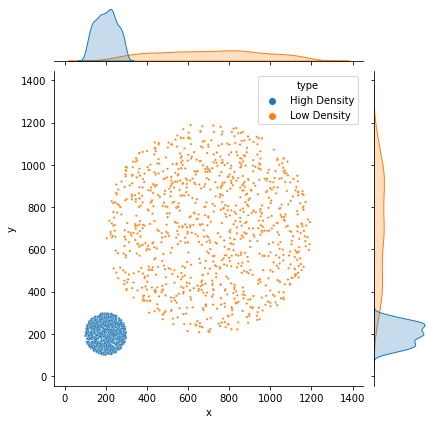

In [5]:
# Plot the simulated dataset
sns.jointplot(data=df,x='x',y='y',hue='type', s=5)

# 2. Compute the Dissimilary Matrix (DS)

The first step in almost all dimensionality reduction methods is to compute a dissimilarity matrix between all the samples. We do that here using the Euclidean distance

In [6]:
D = squareform(pdist(df[['x','y']].values,'euclidean'))

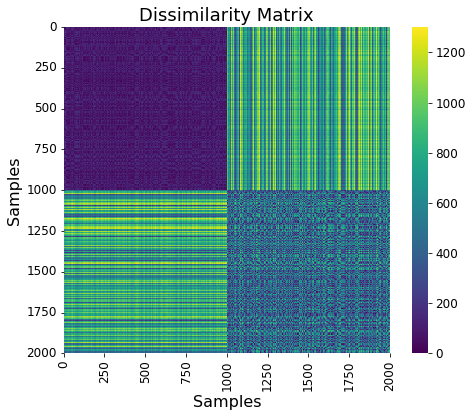

In [7]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
mat = sns.heatmap(D, cmap='viridis', square='True')
ax.set_title('Dissimilarity Matrix', fontsize=18)
ax.set_xlabel('Samples', fontsize=16)
ax.set_ylabel('Samples', fontsize=16)
ax.set_xticks([0,250,500,750,1000,1250,1500,1750,2000])
ax.set_xticklabels([0,250,500,750,1000,1250,1500,1750,2000], fontsize=12)
ax.set_yticks([0,250,500,750,1000,1250,1500,1750,2000])
ax.set_yticklabels([0,250,500,750,1000,1250,1500,1750,2000], fontsize=12)
cbar = mat.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.label.set_size(26)
cbar.ax.yaxis.set_label_position('left')

# 3. Estimate point-wise variance for a few representative perplexity values

In T-SNE, users set a desired perplexity value that the algorithm uses to estimate the variance of the Gaussian kernels centered at each sample that is later used to compute the affinity matrix. Below we generate those variance estimates for two different scenarios: PP = 5. and PP = 50.

In [8]:
# Estimate variances for each sample under two different desired perplexity values
var_dict = {}
for PP in [5., 50.]:
    var_dict[PP], _ = gauss_var_search(D,PP,tol=1e-5,n_attempts=50, beta_init=1)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [9]:
# Convert results from a dictionary to a Pandas dataframe
var_df = pd.DataFrame.from_dict(var_dict)
var_df.columns.name='Perplexity'
var_df.index.name = 'Sample ID'
var_df['type'] = df['type']

In [10]:
# Compute the mean values (peak location for histograms plotted below)
var_df.groupby('type').mean()

Perplexity,5.0,50.0
type,,
High Density,9.438442,112.047938
Low Density,233.378672,2750.996617


In [11]:
# Plot the distribution of variance estimate values for both perplexity scenarios
var_df[5.0].hvplot.kde( title='Distribution of Var Estimates [PP=5]', xlabel='Variance Esimate', ylabel='Density', width=500, c='gray', fontsize={'title':14,'labels':12,'ticks':9}) + \
var_df[50.0].hvplot.kde(title='Distribution of Var Estimates [PP=50]', xlabel='Variance Esimate', ylabel='Density', width=500, c='gray', fontsize={'title':14,'labels':12,'ticks':9})

:Layout
   .Distribution.I  :Distribution   [5.0]   (Density)
   .Distribution.II :Distribution   [50.0]   (Density)

# 4. Compute affinity matrices for the same perplexity values using point-wise variance estimates

We now compute T-SNE affinity matrices in original space for the two perplexity scenarios.

In [12]:
P_dict = {}
distances = (D**2).astype(np.float32, copy=True)
for PP in [5., 50.]:
    P_dict[PP] = squareform(_joint_probabilities(distances, desired_perplexity=PP,verbose=0))

++ INFO[_joint_probabilities]: conditional_P.shape = (2000, 2000)
++ INFO[_joint_probabilities]: P.shape = (2000, 2000)
++ INFO[_joint_probabilities]: P.shape = (1999000,)
++ INFO[_joint_probabilities]: conditional_P.shape = (2000, 2000)
++ INFO[_joint_probabilities]: P.shape = (2000, 2000)
++ INFO[_joint_probabilities]: P.shape = (1999000,)


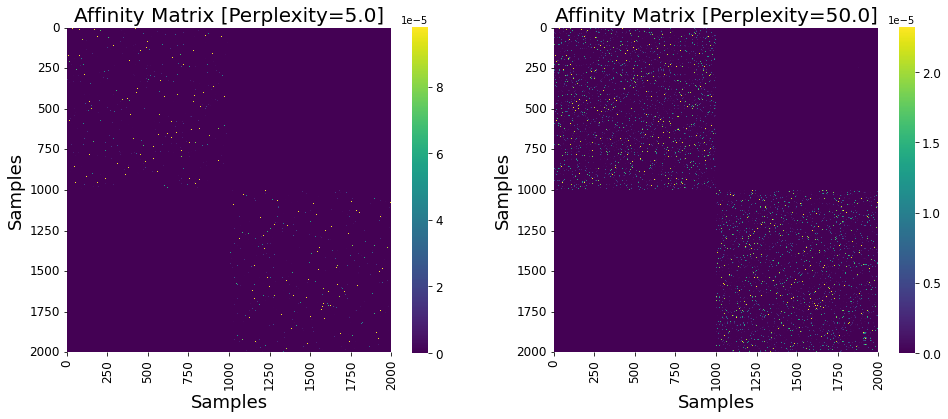

In [13]:
# Plot both perplexity matrices
fig,axs = plt.subplots(1,2,figsize=(16,6))
for i,pp in enumerate([5.,50.]):
    mat = sns.heatmap(P_dict[pp], cmap='viridis', square='True', ax=axs[i], vmax=np.quantile(P_dict[pp],.999))
    axs[i].set_title('Affinity Matrix [Perplexity=%.1f]' % pp, fontsize=20)
    axs[i].set_xlabel('Samples', fontsize=18)
    axs[i].set_ylabel('Samples', fontsize=18)
    axs[i].set_xticks([0,250,500,750,1000,1250,1500,1750,2000])
    axs[i].set_xticklabels([0,250,500,750,1000,1250,1500,1750,2000], fontsize=12)
    axs[i].set_yticks([0,250,500,750,1000,1250,1500,1750,2000])
    axs[i].set_yticklabels([0,250,500,750,1000,1250,1500,1750,2000], fontsize=12)
    cbar = mat.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    cbar.ax.yaxis.label.set_size(26)
    cbar.ax.yaxis.set_label_position('left')

# 5. Estimate Number of Neighbors per Point

Finally, we estimate the number of close neighbors that each point has looking at the affinity matrices. We define close neighbors as points with substantially higher affinity (e.g., those with brigther colors in the affinity matrices). We apply the elbow method to a sorted version of each row in P in order to estimate the number of points with substantially higher affinity.

In [14]:
# Count outliers per row in P
knn_dict = {5.:[],50.:[]}
for pp in [5., 50.]:
    for i in tqdm(np.arange(n)):
        Prow        = P_dict[pp][i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] # Extract one row
        Prow_sorted = pd.DataFrame(Prow, columns=['P']).sort_values(by='P', ascending=False).reset_index(drop=True)
        knl = KneeLocator(Prow_sorted.index, Prow_sorted['P'], curve='convex', direction='decreasing')
        knn_dict[pp].append(knl.knee)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [15]:
# Convert results to pandas dataframe for plotting
knn_df = pd.DataFrame.from_dict(knn_dict)
knn_df.columns.name = 'Perplexity'
knn_df.index.name='Sample ID'
knn_df.hvplot.hist(color=['gray'], legend='top', width=200, subplots=True, xlabel='# Outliers',ylabel='Counts', fontsize={'labels':14, 'ticks':10}) 

:NdLayout   [Default]
   :Histogram   [50.0]   (50.0_count)

In [16]:
# Estimate the location of the peaks in the above histograms
knn_df.mean()

Perplexity
5.0     13.2765
50.0    68.5305
dtype: float64